「TorchTextを使用したテキスト分類」
======
【原題】Text Classification with TorchText

【元URL】https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　御手洗 拓真

【日付】2020年11月02日

【チュトーリアル概要】

TorchTextを使用し、テキスト分類モデルを構築します。

（日本語訳注：2020-11-02時点において、Google Colaboratoryのデフォルトtorchtextはv0.3であり、text_classificationがimportができないため、日本語版チュートリアルでは最初にtorchtextの最新バージョンv0.8を指定してインストールするセルを追加しています。<br>インストールを実行した後は、それを有効にするために、**1度、ランダイムを再起動**してください。上部メニューの「ランタイム」→「ランタイムを再起動」）

In [1]:
!pip install torchtext==0.8.0

TorchTextによるテキストの分類 
=============================

本のチュートリアルでは、`torchtext `に含まれている、以下のような、テキスト分類用データセットの使い方を説明します。

```
-   AG_NEWS
-   SogouNews
-   DBpedia
-   YelpReviewPolarity
-   YelpReviewFull
-   YahooAnswers
-   AmazonReviewPolarity
-   AmazonReviewFull
```



本チュートリアルでは、`TextClassification`データセットの`AG_NEWS`を使用し、教師あり学習の分類アルゴリズムを訓練する方法について解説します。




ngramsを使ってデータを読み込む 
------------------------

bag-of-ngramsで作成した特徴量を使うことで、文章における、局所的な単語の順番に関する情報（の一部）を得ることができます。

実際は、バイグラムまたはトリグラムが利用されることが多いです。

これらを利用することで、1つの単語だけを使用した特徴量よりも、多くの情報を単語のグループから得ることができます。

具体的例を以下に示します。

```
"load data with ngrams"
バイグラムの結果: "load data", "data with", "with ngrams"
トリグラムの結果: "load data with", "data with ngrams"
```

（日本語訳注： 上記は、"load data with ngrams"という1文をバイグラム、もしくはトリグラムとして読み込んだ結果を表示しています。

バイグラムで読み込んだ場合、2つの単語を1セットとして切り出し、トリグラムで読み込んだ場合は、3つの単語を1セットとして切り出します。

その際、切り出しは被りが生まれるように1単語ずつずらすのが一般的です。）




`TextClassification `のDatasetクラスは、ngramsメソッドをサポートしています。

例えば`ngrams`を2に設定することで、`datasets`から取得される例文は、単一単語のリストにバイグラムの文字列を加えたものになります。

In [2]:
%matplotlib inline

In [3]:
import torch
import torchtext
from torchtext.datasets import text_classification

In [4]:
NGRAMS = 2
import os
if not os.path.isdir('./.data'):
	os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ag_news_csv.tar.gz: 11.8MB [00:00, 182MB/s]
120000lines [00:06, 18408.87lines/s]
120000lines [00:15, 7897.54lines/s]
7600lines [00:00, 8132.30lines/s]


モデルの定義 
------------

モデルは、[EmbeddingBag](https://pytorch.org/docs/stable/nn.html?highlight=embeddingbag#torch.nn.EmbeddingBag)レイヤーと、線形レイヤーの大きく二つの部分で構成されています（下図参照）。

<br>


`nn.EmbeddingBag`は、「bag」ごとに埋め込みベクトルの平均値を計算してくれます。

各テキストは異なる長さです。

`nn.EmbeddingBag`では各テキストの長さをオフセットに保存しているので、わざわざパディングを実施する必要はありません。

<br>

さらに、`nn.EmbeddingBag`は、埋め込み全体の平均をすぐに計算できるので、テンソルのシーケンスを処理する、速度とメモリ効率を向上させることができます。


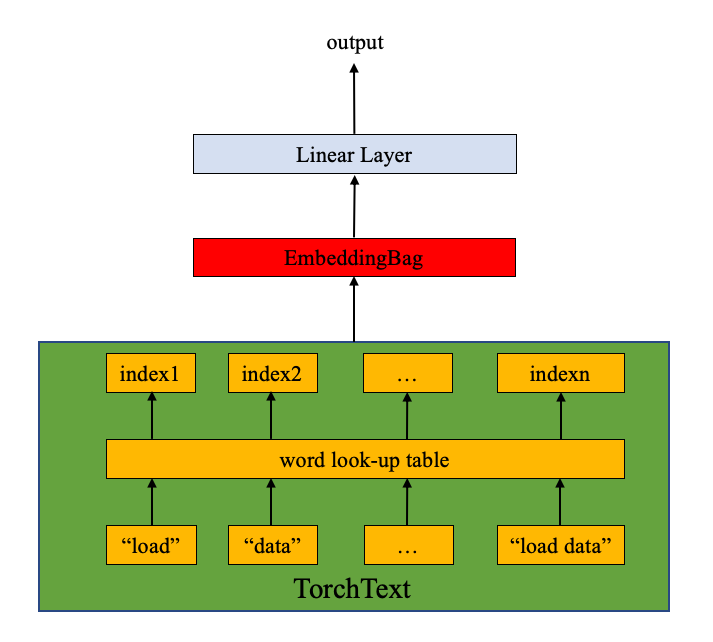

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

インスタンスの初期化
----------------------

`AG_NEWS`データセットには以下の4つのラベルがあるため、クラス数は4になります。

```
1 : 国際関連
2 : スポーツ 
3 : ビジネス 
4 : 科学技術
```

vocabオブジェクトのサイズは、vocabオブジェクト（単語とngramsから構成）、の長さと同じです。

また、クラスの数はラベルの数と同じになるため、AG\_NEWSの場合は4つです。

In [6]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

バッチ生成に使用される関数 
--------------------------

エントリ（日本語訳注：一件ずつのテキストデータのこと）の長さはそれぞれ異なるので、カスタム関数`generate_batch()`を使用してデータのバッチとオフセットを生成します。

この関数は、`torch.utils.data.DataLoader `の`collate_fn `に渡されます。


`collate_fn`への入力は`batch_size`のサイズを持つテンソルのリストで、`collate_fn`関数はそれらをミニバッチとしてまとめます。

ここでは、`collate_fn` がトップレベルの defとして宣言されていることに注意してください。

これにより、各ワーカー（Google Colaboratoryの全セル）でこの関数が利用できるようになります。




元のバッチデータに含まれていたテキストはリストに格納されます。

そして1つのテンソルに結合されて、`NN.EmbeddingBag`に入力されます。

<br>

ここで、`offsets`は、テキストテンソル内における個々のシーケンスの先頭のインデックスを表しています。

すなわち、`offsets`は個々のシーケンスの区切りを示すテンソルとなります。

<br>


`Label`は、個々のテキスト項目のラベルを保存したテンソルです。

In [7]:
from torch.utils.data import DataLoader
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsumはdimで指定されたの要素の累積和を返します。
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [8]:
# 日本語訳注：offsetsの動作例
offsets_example = torch.Tensor([1.0, 2.0, 3.0, 4.0])
offsets_example[:-1].cumsum(dim=0)

tensor([1., 3., 6.])

モデル訓練と結果評価の関数を定義
------------------------------------------------------

[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)は、PyTorchユーザーにおすすめのツールです。

`DataLoader`を使うことで、データの読み込みを簡単に並列化することができます。

(このツールのチュートリアルは[こちら](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)）<br>

<br>

ここでは`DataLoader`を使用して、`AG_NEWS`データセットをロードし、訓練や検証のためにモデルデータをモデルに送ります。

In [9]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # モデル訓練
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # 学習率の更新
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)


def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

データセットを分割し、モデルを実行 
----------------------------------

元の`AG_NEWS`データには検証用データセットがありません。

そこで、学習データセットを訓練データセットと検証用データセットに分割します。

分割率は0.95（訓練）と0.05（検証）とします。


ここでは、PyTorchの中心的ライブラリから、
[torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split)関数を使用します。



損失関数として使用している[`CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)は、`nn.LogSoftmax()`と`nn.NLLLoss()`を1つのクラスにまとめたものです。

クラス数がC個の分類問題を学習する際に、この2つの計算をまとめて実施してくれるため便利です。

<br>

[`SGD`](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)は確率的勾配降下法が実装されており、オプティマイザとして利用します。

初期学習率は4.0に設定されています。

ここでは[`StepLR`](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR)を用いて、エポック単位で学習率を調整しています。

In [10]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 9 seconds
	Loss: 0.0261(train)	|	Acc: 84.7%(train)
	Loss: 0.0003(valid)	|	Acc: 90.1%(valid)
Epoch: 2  | time in 0 minutes, 9 seconds
	Loss: 0.0119(train)	|	Acc: 93.7%(train)
	Loss: 0.0003(valid)	|	Acc: 91.1%(valid)
Epoch: 3  | time in 0 minutes, 9 seconds
	Loss: 0.0069(train)	|	Acc: 96.5%(train)
	Loss: 0.0003(valid)	|	Acc: 90.7%(valid)
Epoch: 4  | time in 0 minutes, 9 seconds
	Loss: 0.0039(train)	|	Acc: 98.1%(train)
	Loss: 0.0004(valid)	|	Acc: 90.6%(valid)
Epoch: 5  | time in 0 minutes, 9 seconds
	Loss: 0.0023(train)	|	Acc: 99.0%(train)
	Loss: 0.0004(valid)	|	Acc: 90.9%(valid)


GPU上でモデルを実行すると、以下のような情報が出力されます（結果は、実行の度に多少変化します）。

Epoch: 1 \| time in 0 minutes, 11 seconds

```
       Loss: 0.0263(train)     |       Acc: 84.5%(train)
       Loss: 0.0001(valid)     |       Acc: 89.0%(valid)
```

Epoch: 2 \| time in 0 minutes, 10 seconds

```
       Loss: 0.0119(train)     |       Acc: 93.6%(train)
       Loss: 0.0000(valid)     |       Acc: 89.6%(valid)
```

Epoch: 3 \| time in 0 minutes, 9 seconds

```
       Loss: 0.0069(train)     |       Acc: 96.4%(train)
       Loss: 0.0000(valid)     |       Acc: 90.5%(valid)
```

Epoch: 4 \| time in 0 minutes, 11 seconds

```
       Loss: 0.0038(train)     |       Acc: 98.2%(train)
       Loss: 0.0000(valid)     |       Acc: 90.4%(valid)
```

Epoch: 5 \| time in 0 minutes, 11 seconds

```
       Loss: 0.0022(train)     |       Acc: 99.0%(train)
       Loss: 0.0000(valid)     |       Acc: 91.0%(valid)
```



テストデータセットでモデルを評価
------------------------------------




In [11]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0003(test)	|	Acc: 90.0%(test)


テストデータセットに対する分類結果を確認しましょう。

以下のような情報が出力されます。

       Loss: 0.0237(test)      |       Acc: 90.5%(test)




適当なニュースでテスト 
------------------------

今までのベストモデルを使って、ゴルフニュースのデータセットに対する分類を試してみましょう。


`AG_NEWS`データセットのラベル情報は[こちら](https://pytorch.org/text/datasets.html?highlight=ag_news#torchtext.datasets.AG_NEWS)で確認できます。

In [13]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}


def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."


vocab = train_dataset.get_vocab()
model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, model, vocab, 2)])

# 日本語訳注：上記はゴルフ関連の記事文章なので、Sportsに分類されて欲しいです。

This is a Sports news


本チュートリアルに掲載されているコードは[こちらのGitHub](https://github.com/pytorch/text/tree/master/examples/text_classification)でも公開されています。 